In [16]:
import pandas as pd
import numpy as np
import os
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
import math
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import warnings
warnings.filterwarnings('ignore')

In [17]:
from matplotlib import font_manager, rc
font_path= 'C:/Windows/Fonts/NGULIM.TTF'
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

#### 통합 데이터 불러오기

In [18]:
df = pd.read_csv('../data_2/full형매변환.csv') 
print(df.shape)

df_copy = df.copy()

# 일단 농가 결측치는 제거
df_copy.dropna(subset=['농가근내평균'], inplace=True)
print(df_copy.shape)

# 형매 결측치 0채우기
print(df_copy.isna().sum())
df_copy['형매_bi'].fillna('3마리미만', inplace=True) # 안 하고 하면 형매bi도 0 채워짐
df_copy.fillna(0, inplace=True)
print('=====')
print(f"결측치 총 개수:{df_copy.isna().sum(axis=1).sum()}")
print(df_copy.형매_bi.value_counts())

(99848, 19)
(76307, 19)
개월령              0
생시체중             0
근내평균             0
도체범위근내평균         0
체고               0
체장               0
형매도축수        55263
형매도체평균       55263
형매근내평균       55263
형매근내평균가산     55263
출산여부_6개월내        0
농가근내평균           0
농가근내평균가산         0
근내EPD            0
근내               0
점수               0
농가구분             0
TARGET1          0
형매_bi        55263
dtype: int64
=====
결측치 총 개수:0
3마리미만    65623
3마리이상    10684
Name: 형매_bi, dtype: int64


#### TARGET3 만들기

In [19]:
df_copy['TARGET3'] = df_copy['점수'].apply(lambda x: 1 if 3<=x else 0 if 3 > x else 0)
print(df_copy['TARGET3'].value_counts())
print(df_copy['점수'].value_counts())

1    50906
0    25401
Name: TARGET3, dtype: int64
3    22666
2    21245
4    17241
5    10999
1     4026
0      130
Name: 점수, dtype: int64


##### train_test_split 7:3

In [20]:
print(f"체고 0 인거:{df_copy[df_copy['체고']==0]}")

체고 0 인거:Empty DataFrame
Columns: [개월령, 생시체중, 근내평균, 도체범위근내평균, 체고, 체장, 형매도축수, 형매도체평균, 형매근내평균, 형매근내평균가산, 출산여부_6개월내, 농가근내평균, 농가근내평균가산, 근내EPD, 근내, 점수, 농가구분, TARGET1, 형매_bi, TARGET3]
Index: []


In [21]:
from sklearn.model_selection import train_test_split

X = df_copy.drop(['TARGET1'],axis=1)
Y = df_copy.TARGET1
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state = 2023)

print(f'데이터 셋 70%:{df_copy.shape[0]*0.7}')
print(f'데이터 셋 30%:{df_copy.shape[0]*0.3}')

train = pd.concat([X_train,Y_train], axis=1)
test = pd.concat([X_test,Y_test], axis=1)

print(f'train set:{train.shape[0]}')
print(f'test set:{test.shape[0]}')

데이터 셋 70%:53414.899999999994
데이터 셋 30%:22892.1
train set:53414
test set:22893


In [22]:
model = sm.Logit.from_formula(""" TARGET3 ~ 개월령+ 생시체중+ 
근내평균+도체범위근내평균+체고+체장+C(형매_bi, Treatment("3마리이상"))+형매도체평균+
형매근내평균+형매근내평균가산+C(출산여부_6개월내, Treatment("Y"))
+농가근내평균+농가근내평균가산+근내EPD
+C(농가구분, Treatment("농가소")) """, train).fit()

model.summary()

Optimization terminated successfully.
         Current function value: 0.514918
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                TARGET3   No. Observations:                53414
Model:                          Logit   Df Residuals:                    53398
Method:                           MLE   Df Model:                           15
Date:                Mon, 06 Nov 2023   Pseudo R-squ.:                  0.1916
Time:                        23:04:56   Log-Likelihood:                -27504.
converged:                       True   LL-Null:                       -34022.
Covariance Type:            nonrobust   LLR p-value:                     0.000
=========================================================================================================
                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
Intercept                                -3.4338      0.590     -5.816      0.000      -4.591      -2.277
C(형매_bi, Treatment("3마리이상"))[T.3마리미만]     0.0937      0.039      2.427      0.015       0.018       0.169
C(출산여부_6개월내, Treatment("Y"))[T.N]         0.1383      0.025      5.508      0.000       0.089       0.188
C(농가구분, Treatment("농가소"))[T.우시장소]         0.3368      0.043      7.792      0.000       0.252       0.422
개월령                                      -0.0039      0.001     -2.790      0.005      -0.007      -0.001
생시체중                                      0.0029      0.000     16.114      0.000       0.003       0.003
근내평균                                      0.1724      0.028      6.169      0.000       0.118       0.227
도체범위근내평균                                  0.6739      0.022     31.173      0.000       0.632       0.716
체고                                       -0.0217      0.006     -3.776      0.000      -0.033      -0.010
체장                                        0.0071      0.003      2.514      0.012       0.002       0.013
형매도체평균                                   -0.0020      0.000     -4.781      0.000      -0.003      -0.001
형매근내평균                                    0.1374      0.033      4.212      0.000       0.073       0.201
형매근내평균가산                                  0.1127      0.034      3.344      0.001       0.047       0.179
농가근내평균                                    0.0293      0.016      1.844      0.065      -0.002       0.060
농가근내평균가산                                  0.4027      0.019     20.694      0.000       0.365       0.441
근내EPD                                     0.5745      0.056     10.244      0.000       0.465       0.684
=========================================================================================================
"""

In [23]:
odds_ratios = pd.DataFrame(
    {
        "OR": model.params,
        "Lower CI": model.conf_int()[0],
        "Upper CI": model.conf_int()[1],
    }
)
odds_ratios = np.exp(odds_ratios)
odds_ratios

,OR,Lower CI,Upper CI
Intercept,0.032264,0.010142,0.102636
"C(형매_bi, Treatment(""3마리이상""))[T.3마리미만]",1.098232,1.018209,1.184544
"C(출산여부_6개월내, Treatment(""Y""))[T.N]",1.148319,1.093171,1.206249
"C(농가구분, Treatment(""농가소""))[T.우시장소]",1.400458,1.286708,1.524265
개월령,0.996110,0.993387,0.998842
생시체중,1.002904,1.002550,1.003258
근내평균,1.188110,1.124797,1.254988
도체범위근내평균,1.961902,1.880510,2.046816
체고,0.978583,0.967647,0.989641
체장,1.007167,1.001575,1.012791


In [24]:
model = sm.Logit.from_formula(""" TARGET3 ~ 개월령+ 생시체중+ 
근내평균+도체범위근내평균+체고+체장+C(형매_bi, Treatment("3마리이상"))+형매도체평균+
형매근내평균+형매근내평균가산+C(출산여부_6개월내, Treatment("Y"))
+농가근내평균가산+근내EPD
+C(농가구분, Treatment("농가소")) """, train).fit()

model.summary()

Optimization terminated successfully.
         Current function value: 0.514949
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                TARGET3   No. Observations:                53414
Model:                          Logit   Df Residuals:                    53399
Method:                           MLE   Df Model:                           14
Date:                Mon, 06 Nov 2023   Pseudo R-squ.:                  0.1915
Time:                        23:04:57   Log-Likelihood:                -27506.
converged:                       True   LL-Null:                       -34022.
Covariance Type:            nonrobust   LLR p-value:                     0.000
=========================================================================================================
                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
Intercept                                -3.3253      0.587     -5.661      0.000      -4.477      -2.174
C(형매_bi, Treatment("3마리이상"))[T.3마리미만]     0.0945      0.039      2.449      0.014       0.019       0.170
C(출산여부_6개월내, Treatment("Y"))[T.N]         0.1412      0.025      5.634      0.000       0.092       0.190
C(농가구분, Treatment("농가소"))[T.우시장소]         0.3283      0.043      7.639      0.000       0.244       0.413
개월령                                      -0.0039      0.001     -2.804      0.005      -0.007      -0.001
생시체중                                      0.0029      0.000     16.193      0.000       0.003       0.003
근내평균                                      0.1736      0.028      6.214      0.000       0.119       0.228
도체범위근내평균                                  0.6744      0.022     31.197      0.000       0.632       0.717
체고                                       -0.0214      0.006     -3.731      0.000      -0.033      -0.010
체장                                        0.0070      0.003      2.480      0.013       0.001       0.013
형매도체평균                                   -0.0020      0.000     -4.836      0.000      -0.003      -0.001
형매근내평균                                    0.1388      0.033      4.255      0.000       0.075       0.203
형매근내평균가산                                  0.1116      0.034      3.310      0.001       0.046       0.178
농가근내평균가산                                  0.4324      0.011     39.541      0.000       0.411       0.454
근내EPD                                     0.5796      0.056     10.347      0.000       0.470       0.689
=========================================================================================================
"""

In [25]:
odds_ratios = pd.DataFrame(
    {
        "OR": model.params,
        "Lower CI": model.conf_int()[0],
        "Upper CI": model.conf_int()[1],
    }
)
odds_ratios = np.exp(odds_ratios)
odds_ratios

,OR,Lower CI,Upper CI
Intercept,0.035962,0.011371,0.113733
"C(형매_bi, Treatment(""3마리이상""))[T.3마리미만]",1.099117,1.019040,1.185486
"C(출산여부_6개월내, Treatment(""Y""))[T.N]",1.151647,1.096444,1.209629
"C(농가구분, Treatment(""농가소""))[T.우시장소]",1.388616,1.276432,1.510660
개월령,0.996090,0.993367,0.998821
생시체중,1.002916,1.002563,1.003270
근내평균,1.189545,1.126171,1.256484
도체범위근내평균,1.962864,1.881435,2.047818
체고,0.978843,0.967909,0.989900
체장,1.007070,1.001480,1.012692


#### 유의한 변수만 고르기

In [26]:
model = sm.Logit.from_formula(""" TARGET3 ~ 개월령+ 생시체중+ 
근내평균+도체범위근내평균+체고+체장+C(형매_bi, Treatment("3마리이상"))+형매도체평균+
형매근내평균+형매근내평균가산+C(출산여부_6개월내, Treatment("Y"))
+농가근내평균가산+근내EPD
+C(농가구분, Treatment("농가소")) """, train).fit()

model.summary()

Optimization terminated successfully.
         Current function value: 0.514949
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                TARGET3   No. Observations:                53414
Model:                          Logit   Df Residuals:                    53399
Method:                           MLE   Df Model:                           14
Date:                Mon, 06 Nov 2023   Pseudo R-squ.:                  0.1915
Time:                        23:05:03   Log-Likelihood:                -27506.
converged:                       True   LL-Null:                       -34022.
Covariance Type:            nonrobust   LLR p-value:                     0.000
=========================================================================================================
                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
Intercept                                -3.3253      0.587     -5.661      0.000      -4.477      -2.174
C(형매_bi, Treatment("3마리이상"))[T.3마리미만]     0.0945      0.039      2.449      0.014       0.019       0.170
C(출산여부_6개월내, Treatment("Y"))[T.N]         0.1412      0.025      5.634      0.000       0.092       0.190
C(농가구분, Treatment("농가소"))[T.우시장소]         0.3283      0.043      7.639      0.000       0.244       0.413
개월령                                      -0.0039      0.001     -2.804      0.005      -0.007      -0.001
생시체중                                      0.0029      0.000     16.193      0.000       0.003       0.003
근내평균                                      0.1736      0.028      6.214      0.000       0.119       0.228
도체범위근내평균                                  0.6744      0.022     31.197      0.000       0.632       0.717
체고                                       -0.0214      0.006     -3.731      0.000      -0.033      -0.010
체장                                        0.0070      0.003      2.480      0.013       0.001       0.013
형매도체평균                                   -0.0020      0.000     -4.836      0.000      -0.003      -0.001
형매근내평균                                    0.1388      0.033      4.255      0.000       0.075       0.203
형매근내평균가산                                  0.1116      0.034      3.310      0.001       0.046       0.178
농가근내평균가산                                  0.4324      0.011     39.541      0.000       0.411       0.454
근내EPD                                     0.5796      0.056     10.347      0.000       0.470       0.689
=========================================================================================================
"""

In [27]:
train_copy = train.copy()

pred_y_1 = model.predict(train)

train_copy['probability_tr'] = pred_y_1

print(len(train_copy))
train_copy.head()

53414


,개월령,생시체중,근내평균,도체범위근내평균,체고,체장,형매도축수,형매도체평균,형매근내평균,형매근내평균가산,...,농가근내평균,농가근내평균가산,근내EPD,근내,점수,농가구분,형매_bi,TARGET3,TARGET1,probability_tr
74658,51,632.14,2.50,2.40,131.1,152.9,0.0,0.00,0.0,0.00,...,4.44,-0.50,-0.03,3,2,농가소,3마리미만,0,0,0.182854
47151,38,748.21,5.00,5.58,132.7,158.0,0.0,0.00,0.0,0.00,...,5.67,-0.68,0.29,7,5,농가소,3마리미만,1,1,0.829156
65363,50,737.50,4.19,5.67,129.2,137.1,6.0,377.17,5.0,0.04,...,5.31,1.13,-0.04,7,4,농가소,3마리이상,1,0,0.854965
73951,50,867.86,5.12,6.00,129.9,146.7,0.0,0.00,0.0,0.00,...,5.84,0.48,0.42,8,5,농가소,3마리미만,1,1,0.939481
64019,54,671.43,4.51,4.72,128.1,147.4,0.0,0.00,0.0,0.00,...,4.73,-0.57,0.06,3,2,농가소,3마리미만,0,0,0.637913


In [28]:
# train set 만들기
test_copy = test.copy()

pred_y = model.predict(test_copy)

test_copy['probability'] = pred_y

print(len(test_copy))
test_copy.head()

22893


,개월령,생시체중,근내평균,도체범위근내평균,체고,체장,형매도축수,형매도체평균,형매근내평균,형매근내평균가산,...,농가근내평균,농가근내평균가산,근내EPD,근내,점수,농가구분,형매_bi,TARGET3,TARGET1,probability
24682,58,692.86,4.16,4.54,131.3,154.1,0.0,0.0,0.0,0.00,...,4.67,0.28,0.08,6,4,농가소,3마리미만,1,0,0.717081
99156,48,695.00,5.22,5.33,128.6,149.9,0.0,0.0,0.0,0.00,...,5.67,0.49,0.34,8,5,우시장소,3마리미만,1,1,0.908058
29604,33,650.00,4.93,5.14,125.8,143.9,0.0,0.0,0.0,0.00,...,4.43,-0.62,0.23,6,4,농가소,3마리미만,1,0,0.765836
4970,44,825.00,4.89,5.82,134.9,157.6,0.0,0.0,0.0,0.00,...,4.42,0.06,0.49,7,5,농가소,3마리미만,1,1,0.909585
98627,30,524.00,4.78,3.80,125.8,143.9,3.0,458.0,4.0,-1.81,...,6.00,1.52,0.06,4,3,우시장소,3마리이상,1,0,0.559042


In [14]:
from performance import performance

In [29]:
test_copy.to_excel('../result/result_345.xlsx')

In [30]:
train_copy['prob_5'] = train_copy['probability_tr'].apply(lambda x: 1 if 0.5<= x else 0 if 0<x<5 else x)
train_copy['prob_6'] = train_copy['probability_tr'].apply(lambda x: 1 if 0.6<= x else 0 if 0<x<6 else x)
train_copy['prob_7'] = train_copy['probability_tr'].apply(lambda x: 1 if 0.7<= x else 0 if 0<x<7 else x)
train_copy['prob_8'] = train_copy['probability_tr'].apply(lambda x: 1 if 0.8<= x else 0 if 0<x<8 else x)
train_copy['prob_9'] = train_copy['probability_tr'].apply(lambda x: 1 if 0.9<= x else 0 if 0<x<9 else x)

train_copy['prob_85'] = train_copy['probability_tr'].apply(lambda x: 1 if 0.85<= x else 0 if 0<x<85 else x)


In [31]:
test_copy['prob_5'] = test_copy['probability'].apply(lambda x: 1 if 0.5<= x else 0 if 0<x<5 else x)
test_copy['prob_6'] = test_copy['probability'].apply(lambda x: 1 if 0.6<= x else 0 if 0<x<6 else x)
test_copy['prob_7'] = test_copy['probability'].apply(lambda x: 1 if 0.7<= x else 0 if 0<x<7 else x)
test_copy['prob_8'] = test_copy['probability'].apply(lambda x: 1 if 0.8<= x else 0 if 0<x<8 else x)
test_copy['prob_9'] = test_copy['probability'].apply(lambda x: 1 if 0.9<= x else 0 if 0<x<9 else x)

test_copy['prob_85'] = test_copy['probability'].apply(lambda x: 1 if 0.85<= x else 0 if 0<x<85 else x)

In [32]:
print(len(test_copy[test_copy['prob_5'].isnull()==False]))
print(len(test_copy[test_copy['prob_6'].isnull()==False]))
print(len(test_copy[test_copy['prob_7'].isnull()==False]))
print(len(test_copy[test_copy['prob_8'].isnull()==False]))
print(len(test_copy[test_copy['prob_9'].isnull()==False]))

22893
22893
22893
22893
22893


In [33]:
print(f"3이상개수:{len(test_copy[test_copy['점수']>=3])}")
print(f"TARGET3개수:{len(test_copy[test_copy['TARGET3']==1])}")
print('========================================='*2)
print(f"0.5이상개수:{len(test_copy[test_copy['probability']>=0.5])}")
print(f"prob_5개수:{len(test_copy[test_copy['prob_5']==1])}")
print('========================================='*2)
print(f"0.6이상개수:{len(test_copy[test_copy['probability']>=0.6])}")
print(f"prob_6개수:{len(test_copy[test_copy['prob_6']==1])}")
print('========================================='*2)
print(f"0.7이상개수:{len(test_copy[test_copy['probability']>=0.7])}")
print(f"prob_7개수:{len(test_copy[test_copy['prob_7']==1])}")
print('========================================='*2)
print(f"0.8이상개수:{len(test_copy[test_copy['probability']>=0.8])}")
print(f"prob_8개수:{len(test_copy[test_copy['prob_8']==1])}")
print('========================================='*2)
print(f"0.9이상개수:{len(test_copy[test_copy['probability']>=0.9])}")
print(f"prob_9개수:{len(test_copy[test_copy['prob_9']==1])}")

3이상개수:15330
TARGET3개수:15330
0.5이상개수:17683
prob_5개수:17683
0.6이상개수:15240
prob_6개수:15240
0.7이상개수:12118
prob_7개수:12118
0.8이상개수:8120
prob_8개수:8120
0.9이상개수:3385
prob_9개수:3385


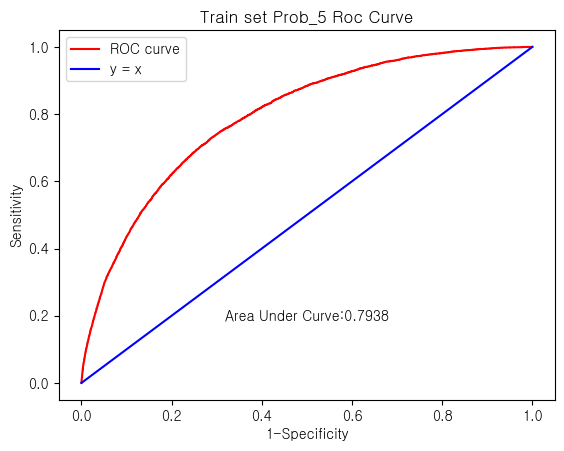

In [34]:
# roc curve, auc train set
fpr, tpr, thresholds = roc_curve(train_copy['TARGET1'], train_copy['probability_tr'])

# auc 계산

plt.plot(fpr, tpr, color = 'red', label = 'ROC curve')
plt.plot([0, 1], [0, 1], color = 'blue', label = 'y = x') # y = x 직선 표시

auc = roc_auc_score(train_copy['TARGET1'], train_copy['probability_tr'])
plt.text(0.5, 0.2, f"Area Under Curve:{auc:.4f}", ha='center', va='center', fontsize=10)
plt.title('Train set Prob_5 Roc Curve')
plt.xlabel('1-Specificity')
plt.ylabel('Sensitivity')

plt.legend() # 그래프 라벨 표시

plt.show()

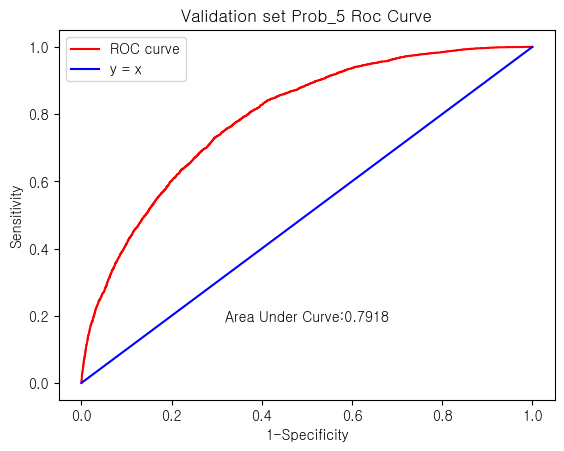

In [35]:
# roc curve, auc validation set
fpr, tpr, thresholds = roc_curve(test_copy['TARGET1'], test_copy['probability'])

# auc 계산

plt.plot(fpr, tpr, color = 'red', label = 'ROC curve')
plt.plot([0, 1], [0, 1], color = 'blue', label = 'y = x') # y = x 직선 표시

auc = roc_auc_score(test_copy['TARGET1'], test_copy['probability'])
plt.text(0.5, 0.2, f"Area Under Curve:{auc:.4f}", ha='center', va='center', fontsize=10)
plt.title('Validation set Prob_5 Roc Curve')
plt.xlabel('1-Specificity')
plt.ylabel('Sensitivity')

plt.legend() # 그래프 라벨 표시

plt.show()

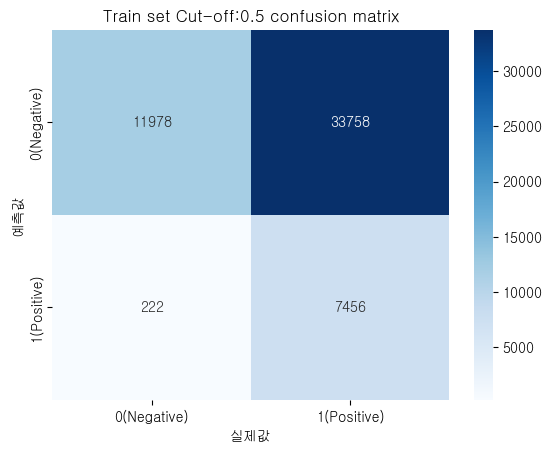

True Positive:7456
True Negative:11978
False Positive:33758
False Negative:222


,Metric,Value,CI_Lower,CI_Upper
0,Sensitivity,97.108622,96.733810,97.483434
1,Specificity,26.189435,25.786487,26.592383
2,Accuracy,36.383720,35.975714,36.791725
3,PPV,18.090940,17.719293,18.462587
4,NPV,98.180328,97.943144,98.417512
5,F_0.5_score,21.607335,NaN,NaN


In [36]:
# cut-off 0.5 train set
cm = confusion_matrix(train_copy['TARGET1'],train_copy['prob_5'])

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('실제값')
plt.ylabel('예측값')
plt.title('Train set Cut-off:0.5 confusion matrix')
plt.xticks([0.5,1.5],['0(Negative)','1(Positive)'])
plt.yticks([0.5,1.5],['0(Negative)','1(Positive)'])
plt.show()

print(f"True Positive:{len(train_copy[(train_copy['prob_5']==1)&(train_copy['TARGET1']==1)])}")
print(f"True Negative:{len(train_copy[(train_copy['prob_5']==0)&(train_copy['TARGET1']==0)])}")
print(f"False Positive:{len(train_copy[(train_copy['prob_5']==1)&(train_copy['TARGET1']==0)])}")
print(f"False Negative:{len(train_copy[(train_copy['prob_5']==0)&(train_copy['TARGET1']==1)])}")

performance(TP=len(train_copy[(train_copy['prob_5']==1)&(train_copy['TARGET1']==1)]),
            TN=len(train_copy[(train_copy['prob_5']==0)&(train_copy['TARGET1']==0)]),
            FP=len(train_copy[(train_copy['prob_5']==1)&(train_copy['TARGET1']==0)]),
            FN=len(train_copy[(train_copy['prob_5']==0)&(train_copy['TARGET1']==1)]),
            BETA=0.5)

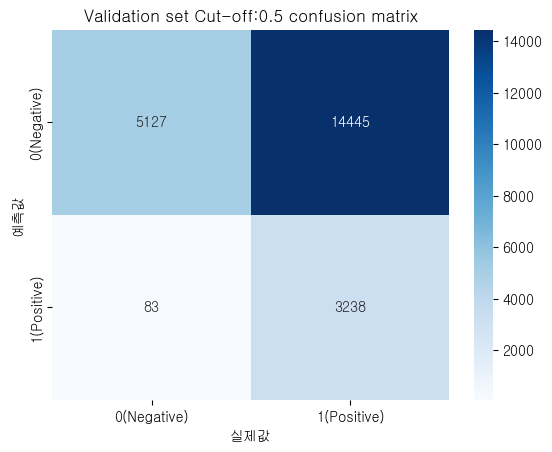

True Positive:3238
True Negative:5127
False Positive:14445
False Negative:83


,Metric,Value,CI_Lower,CI_Upper
0,Sensitivity,97.500753,96.969831,98.031674
1,Specificity,26.195586,25.579567,26.811604
2,Accuracy,36.539554,35.915764,37.163343
3,PPV,18.311373,17.741314,18.881431
4,NPV,98.406910,98.066917,98.746903
5,F_0.5_score,21.862720,NaN,NaN


In [37]:
# cut-off 0.5 validation set
cm = confusion_matrix(test_copy['TARGET1'], test_copy['prob_5'])

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('실제값')
plt.ylabel('예측값')
plt.title('Validation set Cut-off:0.5 confusion matrix')
plt.xticks([0.5,1.5],['0(Negative)','1(Positive)'])
plt.yticks([0.5,1.5],['0(Negative)','1(Positive)'])
plt.show()

print(f"True Positive:{len(test_copy[(test_copy['prob_5']==1)&(test_copy['TARGET1']==1)])}")
print(f"True Negative:{len(test_copy[(test_copy['prob_5']==0)&(test_copy['TARGET1']==0)])}")
print(f"False Positive:{len(test_copy[(test_copy['prob_5']==1)&(test_copy['TARGET1']==0)])}")
print(f"False Negative:{len(test_copy[(test_copy['prob_5']==0)&(test_copy['TARGET1']==1)])}")

performance(TP=len(test_copy[(test_copy['prob_5']==1)&(test_copy['TARGET1']==1)]),
            TN=len(test_copy[(test_copy['prob_5']==0)&(test_copy['TARGET1']==0)]),
            FP=len(test_copy[(test_copy['prob_5']==1)&(test_copy['TARGET1']==0)]),
            FN=len(test_copy[(test_copy['prob_5']==0)&(test_copy['TARGET1']==1)]),
            BETA=0.5)

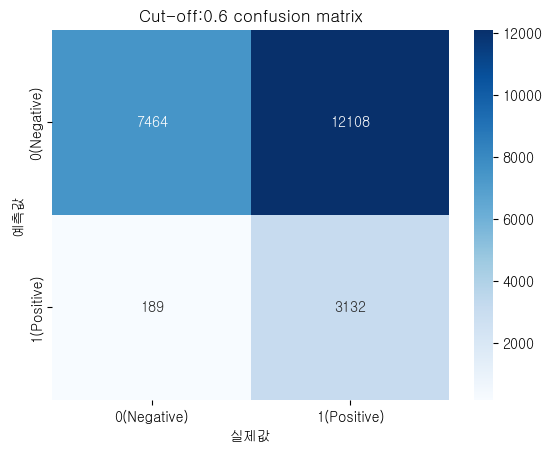

True Positive:3132
True Negative:7464
False Positive:12108
False Negative:189


,Metric,Value,CI_Lower,CI_Upper
0,Sensitivity,94.308943,93.521001,95.096886
1,Specificity,38.136113,37.455617,38.816608
2,Accuracy,46.284891,45.638980,46.930801
3,PPV,20.551181,19.909638,21.192724
4,NPV,97.530380,97.182664,97.878097
5,F_0.5_score,24.361787,NaN,NaN


In [38]:
# cut-off 0.6
cm = confusion_matrix(test_copy['TARGET1'], test_copy['prob_6'])

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('실제값')
plt.ylabel('예측값')
plt.title('Cut-off:0.6 confusion matrix')
plt.xticks([0.5,1.5],['0(Negative)','1(Positive)'])
plt.yticks([0.5,1.5],['0(Negative)','1(Positive)'])
plt.show()

print(f"True Positive:{len(test_copy[(test_copy['prob_6']==1)&(test_copy['TARGET1']==1)])}")
print(f"True Negative:{len(test_copy[(test_copy['prob_6']==0)&(test_copy['TARGET1']==0)])}")
print(f"False Positive:{len(test_copy[(test_copy['prob_6']==1)&(test_copy['TARGET1']==0)])}")
print(f"False Negative:{len(test_copy[(test_copy['prob_6']==0)&(test_copy['TARGET1']==1)])}")

performance(TP=len(test_copy[(test_copy['prob_6']==1)&(test_copy['TARGET1']==1)]),
            TN=len(test_copy[(test_copy['prob_6']==0)&(test_copy['TARGET1']==0)]),
            FP=len(test_copy[(test_copy['prob_6']==1)&(test_copy['TARGET1']==0)]),
            FN=len(test_copy[(test_copy['prob_6']==0)&(test_copy['TARGET1']==1)]),
            BETA=0.5)

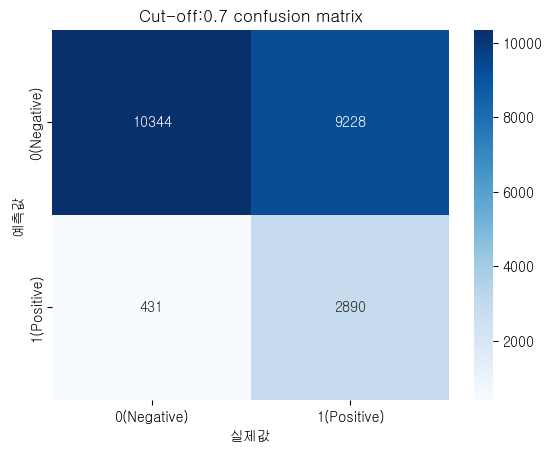

True Positive:2890
True Negative:10344
False Positive:9228
False Negative:431


,Metric,Value,CI_Lower,CI_Upper
0,Sensitivity,87.021981,85.878997,88.164966
1,Specificity,52.851012,52.151651,53.550372
2,Accuracy,57.808064,57.168309,58.447819
3,PPV,23.848820,23.090046,24.607594
4,NPV,96.000000,95.629990,96.370010
5,F_0.5_score,27.899523,NaN,NaN


In [39]:
# cut-off 0.7
cm = confusion_matrix(test_copy['TARGET1'], test_copy['prob_7'])

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('실제값')
plt.ylabel('예측값')
plt.title('Cut-off:0.7 confusion matrix')
plt.xticks([0.5,1.5],['0(Negative)','1(Positive)'])
plt.yticks([0.5,1.5],['0(Negative)','1(Positive)'])
plt.show()

print(f"True Positive:{len(test_copy[(test_copy['prob_7']==1)&(test_copy['TARGET1']==1)])}")
print(f"True Negative:{len(test_copy[(test_copy['prob_7']==0)&(test_copy['TARGET1']==0)])}")
print(f"False Positive:{len(test_copy[(test_copy['prob_7']==1)&(test_copy['TARGET1']==0)])}")
print(f"False Negative:{len(test_copy[(test_copy['prob_7']==0)&(test_copy['TARGET1']==1)])}")

performance(TP=len(test_copy[(test_copy['prob_7']==1)&(test_copy['TARGET1']==1)]),
            TN=len(test_copy[(test_copy['prob_7']==0)&(test_copy['TARGET1']==0)]),
            FP=len(test_copy[(test_copy['prob_7']==1)&(test_copy['TARGET1']==0)]),
            FN=len(test_copy[(test_copy['prob_7']==0)&(test_copy['TARGET1']==1)]),
            BETA=0.5)

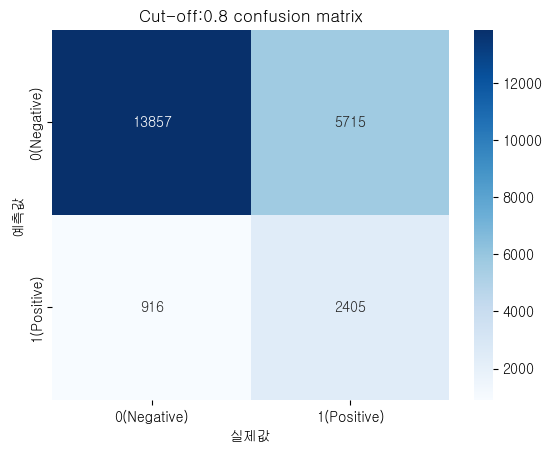

True Positive:2405
True Negative:13857
False Positive:5715
False Negative:916


,Metric,Value,CI_Lower,CI_Upper
0,Sensitivity,72.417946,70.897896,73.937997
1,Specificity,70.800123,70.163113,71.437132
2,Accuracy,71.034814,70.447219,71.622410
3,PPV,29.618227,28.625139,30.611314
4,NPV,93.799499,93.410601,94.188397
5,F_0.5_score,33.588447,NaN,NaN


In [40]:
# cut-off 0.8
cm = confusion_matrix(test_copy['TARGET1'], test_copy['prob_8'])

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('실제값')
plt.ylabel('예측값')
plt.title('Cut-off:0.8 confusion matrix')
plt.xticks([0.5,1.5],['0(Negative)','1(Positive)'])
plt.yticks([0.5,1.5],['0(Negative)','1(Positive)'])
plt.show()

print(f"True Positive:{len(test_copy[(test_copy['prob_8']==1)&(test_copy['TARGET1']==1)])}")
print(f"True Negative:{len(test_copy[(test_copy['prob_8']==0)&(test_copy['TARGET1']==0)])}")
print(f"False Positive:{len(test_copy[(test_copy['prob_8']==1)&(test_copy['TARGET1']==0)])}")
print(f"False Negative:{len(test_copy[(test_copy['prob_8']==0)&(test_copy['TARGET1']==1)])}")

performance(TP=len(test_copy[(test_copy['prob_8']==1)&(test_copy['TARGET1']==1)]),
            TN=len(test_copy[(test_copy['prob_8']==0)&(test_copy['TARGET1']==0)]),
            FP=len(test_copy[(test_copy['prob_8']==1)&(test_copy['TARGET1']==0)]),
            FN=len(test_copy[(test_copy['prob_8']==0)&(test_copy['TARGET1']==1)]),
            BETA=0.5)

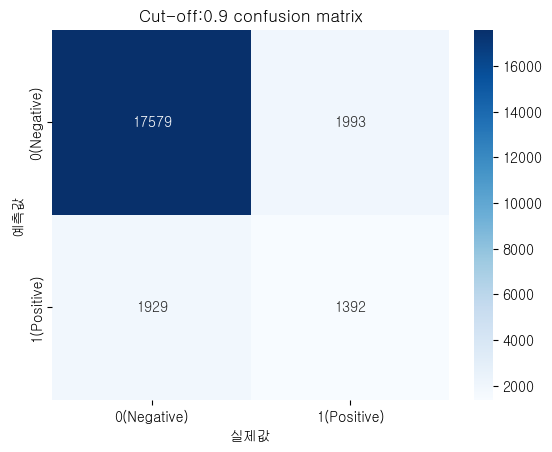

True Positive:1392
True Negative:17579
False Positive:1993
False Negative:1929


,Metric,Value,CI_Lower,CI_Upper
0,Sensitivity,41.915086,40.236906,43.593266
1,Specificity,89.817086,89.393390,90.240781
2,Accuracy,82.868126,82.380034,83.356217
3,PPV,41.122600,39.464955,42.780244
4,NPV,90.111749,89.692859,90.530639
5,F_0.5_score,41.278690,NaN,NaN


In [41]:
# cut-off 0.9
cm = confusion_matrix(test_copy['TARGET1'], test_copy['prob_9'])

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('실제값')
plt.ylabel('예측값')
plt.title('Cut-off:0.9 confusion matrix')
plt.xticks([0.5,1.5],['0(Negative)','1(Positive)'])
plt.yticks([0.5,1.5],['0(Negative)','1(Positive)'])
plt.show()

print(f"True Positive:{len(test_copy[(test_copy['prob_9']==1)&(test_copy['TARGET1']==1)])}")
print(f"True Negative:{len(test_copy[(test_copy['prob_9']==0)&(test_copy['TARGET1']==0)])}")
print(f"False Positive:{len(test_copy[(test_copy['prob_9']==1)&(test_copy['TARGET1']==0)])}")
print(f"False Negative:{len(test_copy[(test_copy['prob_9']==0)&(test_copy['TARGET1']==1)])}")

performance(TP=len(test_copy[(test_copy['prob_9']==1)&(test_copy['TARGET1']==1)]),
            TN=len(test_copy[(test_copy['prob_9']==0)&(test_copy['TARGET1']==0)]),
            FP=len(test_copy[(test_copy['prob_9']==1)&(test_copy['TARGET1']==0)]),
            FN=len(test_copy[(test_copy['prob_9']==0)&(test_copy['TARGET1']==1)]),
            BETA=0.5)

##### 0.85

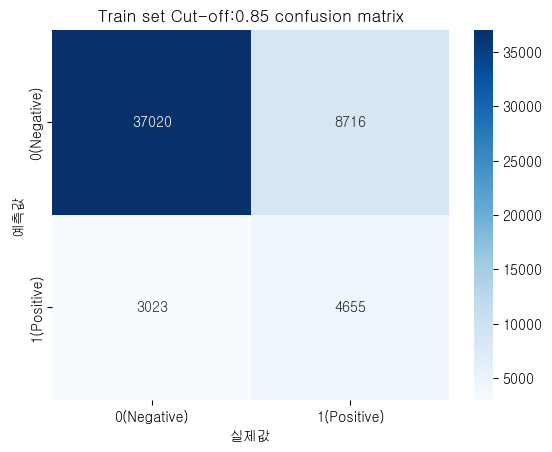

True Positive:4655
True Negative:37020
False Positive:8716
False Negative:3023


,Metric,Value,CI_Lower,CI_Upper
0,Sensitivity,60.627768,59.534912,61.720623
1,Specificity,80.942802,80.582849,81.302755
2,Accuracy,78.022616,77.671438,78.373793
3,PPV,34.814150,34.006676,35.621624
4,NPV,92.450616,92.191852,92.709379
5,F_0.5_score,38.054674,NaN,NaN


In [42]:
# cut-off 0.85 train
cm = confusion_matrix(train_copy['TARGET1'], train_copy['prob_85'])

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('실제값')
plt.ylabel('예측값')
plt.title('Train set Cut-off:0.85 confusion matrix')
plt.xticks([0.5,1.5],['0(Negative)','1(Positive)'])
plt.yticks([0.5,1.5],['0(Negative)','1(Positive)'])
plt.show()

print(f"True Positive:{len(train_copy[(train_copy['prob_85']==1)&(train_copy['TARGET1']==1)])}")
print(f"True Negative:{len(train_copy[(train_copy['prob_85']==0)&(train_copy['TARGET1']==0)])}")
print(f"False Positive:{len(train_copy[(train_copy['prob_85']==1)&(train_copy['TARGET1']==0)])}")
print(f"False Negative:{len(train_copy[(train_copy['prob_85']==0)&(train_copy['TARGET1']==1)])}")

performance(TP=len(train_copy[(train_copy['prob_85']==1)&(train_copy['TARGET1']==1)]),
            TN=len(train_copy[(train_copy['prob_85']==0)&(train_copy['TARGET1']==0)]),
            FP=len(train_copy[(train_copy['prob_85']==1)&(train_copy['TARGET1']==0)]),
            FN=len(train_copy[(train_copy['prob_85']==0)&(train_copy['TARGET1']==1)]),
            BETA=0.5)

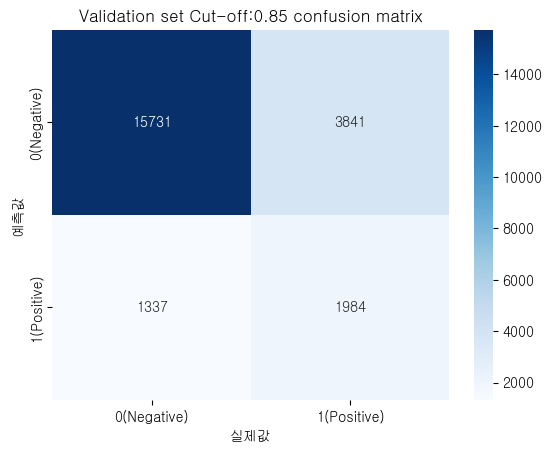

True Positive:1984
True Negative:15731
False Positive:3841
False Negative:1337


,Metric,Value,CI_Lower,CI_Upper
0,Sensitivity,59.741042,58.073068,61.409016
1,Specificity,80.375026,79.818604,80.931447
2,Accuracy,77.381732,76.839789,77.923675
3,PPV,34.060086,32.843045,35.277127
4,NPV,92.166628,91.763515,92.569740
5,F_0.5_score,37.263814,NaN,NaN


In [43]:
# cut-off 0.85 validation
cm = confusion_matrix(test_copy['TARGET1'], test_copy['prob_85'])

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('실제값')
plt.ylabel('예측값')
plt.title('Validation set Cut-off:0.85 confusion matrix')
plt.xticks([0.5,1.5],['0(Negative)','1(Positive)'])
plt.yticks([0.5,1.5],['0(Negative)','1(Positive)'])
plt.show()

print(f"True Positive:{len(test_copy[(test_copy['prob_85']==1)&(test_copy['TARGET1']==1)])}")
print(f"True Negative:{len(test_copy[(test_copy['prob_85']==0)&(test_copy['TARGET1']==0)])}")
print(f"False Positive:{len(test_copy[(test_copy['prob_85']==1)&(test_copy['TARGET1']==0)])}")
print(f"False Negative:{len(test_copy[(test_copy['prob_85']==0)&(test_copy['TARGET1']==1)])}")

performance(TP=len(test_copy[(test_copy['prob_85']==1)&(test_copy['TARGET1']==1)]),
            TN=len(test_copy[(test_copy['prob_85']==0)&(test_copy['TARGET1']==0)]),
            FP=len(test_copy[(test_copy['prob_85']==1)&(test_copy['TARGET1']==0)]),
            FN=len(test_copy[(test_copy['prob_85']==0)&(test_copy['TARGET1']==1)]),
            BETA=0.5)